In [1]:
import cv2
import numpy as np
from scipy import interpolate


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


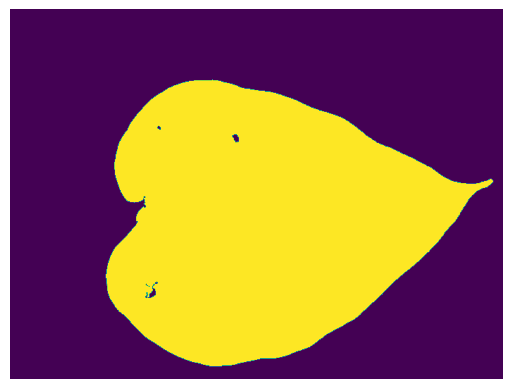

In [18]:
# Load the image and convert it to grayscale
img = cv2.imread('../../leafsnap/leafsnap-dataset/dataset/segmented/field/catalpa_bignonioides/13001269151465.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show(gray)



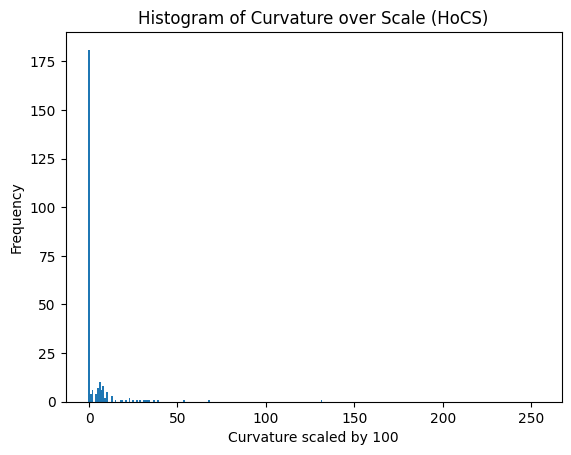

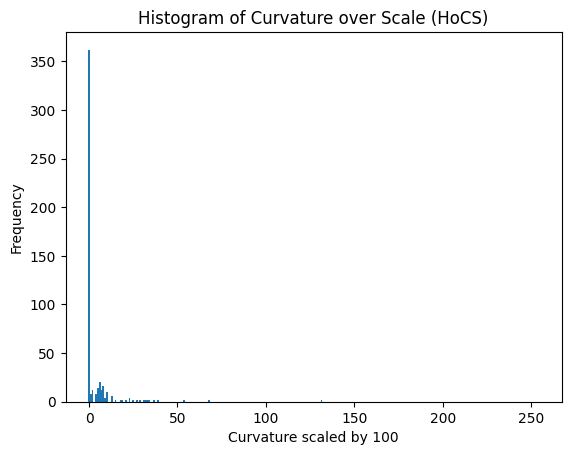

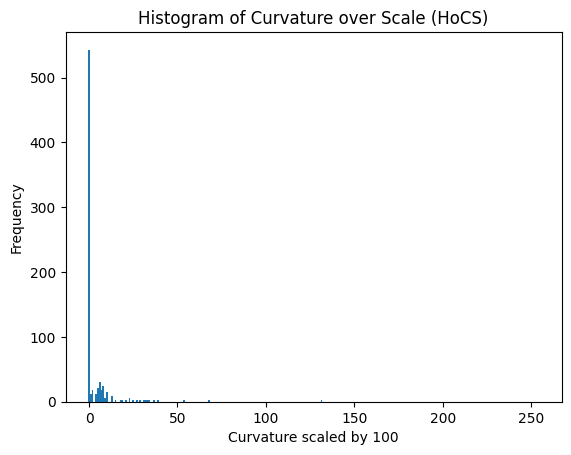

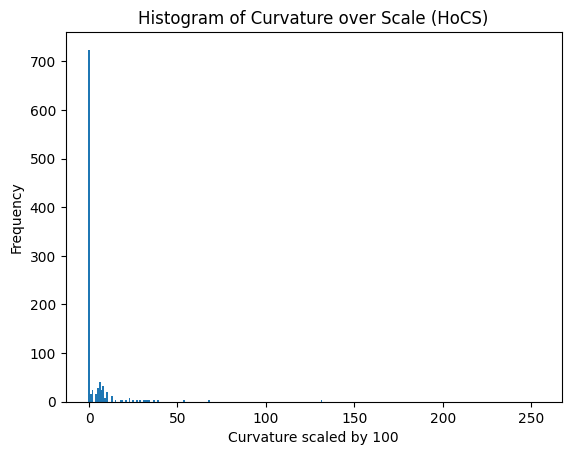

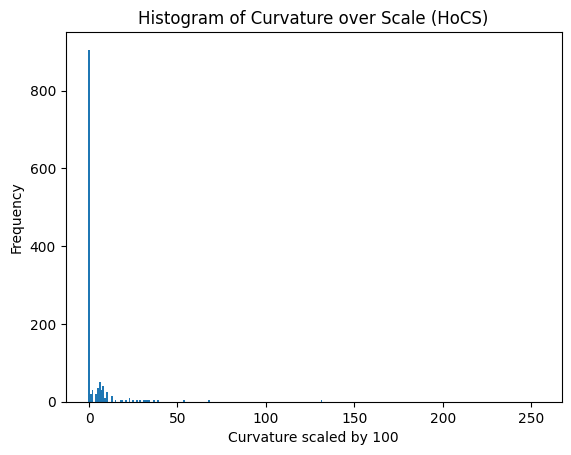

In [20]:

# Find the contours in the image
contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Compute the curvature at each point along the contour
curvature = []
for cnt in contours:
    # Reshape the contour into a 1D array
    cnt = np.squeeze(cnt)
    x = cnt[:,0]
    y = cnt[:,1]
    
    # Interpolate the contour points to obtain a smooth curve
    tck, u = interpolate.splprep([x, y], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = interpolate.splev(u_new, tck, der=0)
    
    # Compute the curvature of the curve
    dx_dt, dy_dt = interpolate.splev(u_new, tck, der=1)
    d2x_dt2, d2y_dt2 = interpolate.splev(u_new, tck, der=2)
    curvature_val = np.abs(dx_dt*d2y_dt2 - dy_dt*d2x_dt2) / (dx_dt**2 + dy_dt**2)**1.5
    curvature.append(curvature_val)

# Generate the curvature image
curvature_scaled = curvature * 5 # Scale up the curvature values

# Generate the curvature image
curvature_image = np.array(curvature_scaled)
curvature_image = np.flip(curvature_image, axis=0)
curvature_image = cv2.normalize(curvature_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
curvature_image = cv2.applyColorMap(curvature_image, cv2.COLORMAP_JET)
show(curvature_image)


# Compute the HoCS feature by taking histograms along each row of the curvature image
num_bins = 256
histograms = []
for i in range(curvature_image.shape[0]):
    row = curvature_image[i,:]
    hist, _ = np.histogram(row, bins=num_bins, range=(0,255))
    histograms.append(hist)
    hist, bins = np.histogram(histograms, bins=num_bins, range=(0, 255))
    plt.figure()
    plt.bar(bins[:-1], hist, width=1)
    plt.title('Histogram of Curvature over Scale (HoCS)')
    plt.xlabel('Curvature scaled by 100')
    plt.ylabel('Frequency')
    plt.show()
    
# Convert the histograms to a feature vector
feature_vector = np.concatenate(histograms)

In [5]:
from plantcv import plantcv as pcv
print(pcv)

<module 'plantcv.plantcv' from 'd:\\anaconda3\\envs\\Plant\\lib\\site-packages\\plantcv\\plantcv\\__init__.py'>


In [15]:
import matplotlib.pyplot as plt
def show(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()